# Normalizing Flows Powered Neural Posterior Estimation for Strong Gravitational Lensing

In [1]:
# Torch
import torch
from torch.utils.data import DataLoader
from torch.distributions import Normal, Uniform

# SBI
from sbi.analysis import pairplot
from sbi.inference import NPE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.utils import BoxUniform, MultipleIndependent
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding

# Others
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import corner
import pickle

# Custom
from analysis.visualization_utils import plot_corner, plot_corner_overlay, plot_corner_image, plot_parity, plot_coverage
from analysis.diagnostic_utils import get_coverage


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/steven/anaconda3/envs/sbi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 1. Data Processing

In [7]:
# === Load Image Data ===

# Function to load image data
def load_image_data(file_path: str) -> torch.Tensor:
    with h5py.File(file_path, 'r') as f:
        data = f["data"][:] 
    data_tensor = torch.tensor(data, dtype=torch.float32)
    return data_tensor

# Load data x_train
x_train_path = "../datasets/train_0/image_data.h5"  
x_train = load_image_data(x_train_path)
print("Loaded Image Training Data Shape:", x_train.shape)

# Load data x_test
x_test_path = "../datasets/test/image_data.h5"
x_test = load_image_data(x_test_path)
print("Loaded Image Test Data Shape:", x_test.shape)


# === Load Parameter Labels ===

# Function to load parameter labels
def load_parameter_labels(file_path: str, keep_columns: list) -> torch.Tensor:
    parameters = pd.read_csv(file_path)
    parameters = parameters[keep_columns]
    parameters_tensor = torch.tensor(parameters.values, dtype=torch.float32)
    return parameters_tensor

keep_columns = [
    "main_deflector_parameters_theta_E",
    "main_deflector_parameters_gamma1",
    "main_deflector_parameters_gamma2",
    "main_deflector_parameters_gamma",
    "main_deflector_parameters_e1",
    "main_deflector_parameters_e2",
    "main_deflector_parameters_center_x",
    "main_deflector_parameters_center_y",
    "source_parameters_center_x",
    "source_parameters_center_y"
    ]
parameter_labels = [r'$\theta_\mathrm{E}$',r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_\mathrm{lens}$',r'$e_1$',r'$e_2$']
param_labels = [r'$\theta_\mathrm{E}$',r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_\mathrm{lens}$',r'$e_1$',
								r'$e_2$',r'$x_\mathrm{lens}$',r'$y_\mathrm{lens}$',r'$x_\mathrm{src}$',r'$y_\mathrm{src}$']

# Load parameters theta_train
theta_train_path = "../datasets/train_0/metadata.csv"
theta_train = load_parameter_labels(theta_train_path, keep_columns)
print("Loaded Parameter Training Labels Shape:", theta_train.shape)

# Load parameters theta_test
theta_test_path = "../datasets/test/metadata.csv"
theta_test = load_parameter_labels(theta_test_path, keep_columns)
print("Loaded Parameter Test Labels Shape:", theta_test.shape)

Loaded Image Training Data Shape: torch.Size([50000, 180, 180])
Loaded Image Test Data Shape: torch.Size([1000, 180, 180])
Loaded Parameter Training Labels Shape: torch.Size([50000, 10])
Loaded Parameter Test Labels Shape: torch.Size([1000, 10])


### 2. Neural Network Architecture

In [6]:
# === Define Neural Network ===

# Define embedding network
embedding_net = CNNEmbedding(
    input_shape=(180, 180),
    in_channels=1,
    out_channels_per_layer=[16, 32, 64], 
    num_conv_layers=3,
    num_linear_layers=2,
    output_dim=40,
    kernel_size=3,
    pool_kernel_size=2
)

# Define density estimator
density_est = "mdn" #mad-rqs and maf and nsf and mdn
density_estimator_build_fun = posterior_nn(
    model=density_est, hidden_features=40, num_transforms=10, embedding_net=embedding_net # 60 # 10-20 
)

# Define inference object (NPE)
inference = NPE(density_estimator=density_estimator_build_fun)

inference = inference.append_simulations(theta_train[:200], x_train[:200])

# Train the density estimator
max_num_epochs = 5
density_estimator = inference.train(max_num_epochs=max_num_epochs, show_train_summary=True)


train_losses = density_estimator.loss_history['train']
val_losses = density_estimator.loss_history['val']
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
help(inference.train)


 Training neural network. Epochs trained: 6
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 6
        Best validation performance: -3.4110
        -------------------------
        


AttributeError: 'NFlowsFlow' object has no attribute 'loss_history'

In [9]:
# loss = density_estimator.loss()

# print(loss)
help(density_estimator)



Help on NFlowsFlow in module sbi.neural_nets.estimators.nflows_flow object:

class NFlowsFlow(sbi.neural_nets.estimators.base.ConditionalDensityEstimator)
 |  NFlowsFlow(net: nflows.flows.base.Flow, input_shape: torch.Size, condition_shape: torch.Size) -> None
 |  
 |  `nflows`- based normalizing flow density estimator.
 |  
 |  Flow type objects already have a .log_prob() and .sample() method, so here we just
 |  wrap them and add the .loss() method.
 |  
 |  Method resolution order:
 |      NFlowsFlow
 |      sbi.neural_nets.estimators.base.ConditionalDensityEstimator
 |      sbi.neural_nets.estimators.base.ConditionalEstimator
 |      torch.nn.modules.module.Module
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, net: nflows.flows.base.Flow, input_shape: torch.Size, condition_shape: torch.Size) -> None
 |      Initialize density estimator which wraps flows from the `nflows` library.
 |      
 |      Args:
 |          net: The raw `nflows

### 3. Training

In [ ]:
# === Training ===

# Pass simulated data to inference object
inference = inference.append_simulations(theta_train, x_train)

# Train the density estimator
max_num_epochs = 30
density_estimator = inference.train(max_num_epochs=max_num_epochs, show_train_summary=True)

# Build the posterior
posterior = inference.build_posterior(density_estimator)

# save posterior 
with open(f"inference_{density_est}{max_num_epochs}.pkl", "wb") as handle:
    pickle.dump(posterior, handle)


#    num_atoms: Number of atoms to use for classification.
#             training_batch_size: Training batch size.
#             learning_rate: Learning rate for Adam optimizer.
#             validation_fraction: The fraction of data to use for validation.
#             stop_after_epochs: The number of epochs to wait for improvement on the
#                 validation set before terminating training.
#             max_num_epochs: Maximum number of epochs to run. If reached, we stop
#                 training even when the validation loss is still decreasing. Otherwise,
#                 we train until validation loss increases (see also `stop_after_epochs`).
#             clip_max_norm: Value at which to clip the total gradient norm in order to
#                 prevent exploding gradients. Use None for no clipping.
#             calibration_kernel: A function to calibrate the loss with respect to the
#                 simulations `x`. See Lueckmann, Gonçalves et al., NeurIPS 2017.
#             resume_training: Can be used in case training time is limited, e.g. on a
#                 cluster. If `True`, the split between train and validation set, the
#                 optimizer, the number of epochs, and the best validation log-prob will
#                 be restored from the last time `.train()` was called.
#             force_first_round_loss: If `True`, train with maximum likelihood,
#                 i.e., potentially ignoring the correction for using a proposal
#                 distribution different from the prior.
#             discard_prior_samples: Whether to discard samples simulated in round 1, i.e.
#                 from the prior. Training may be sped up by ignoring such less targeted
#                 samples.
#             use_combined_loss: Whether to train the neural net also on prior samples
#                 using maximum likelihood in addition to training it on all samples using
#                 atomic loss. The extra MLE loss helps prevent density leaking with
#                 bounded priors.
#             retrain_from_scratch: Whether to retrain the conditional density
#                 estimator for the posterior from scratch each round.
#             show_train_summary: Whether to print the number of epochs and validation
#                 loss and leakage after the training.
#             dataloader_kwargs: Additional or updated kwargs to be passed to the training
#                 and validation dataloaders (like, e.g., a collate_fn)


NameError: name 'inference' is not defined

In [8]:
# === Define Neural Network ===

# Define density estimator
density_est = "maf" #mad-rqs and maf and nsf and mdn
density_estimator_build_fun = posterior_nn(
    model=density_est, hidden_features=40, num_transforms=10, embedding_net=embedding_net # 60 # 10-20 
)

# Define inference object (NPE)
inference = NPE(density_estimator=density_estimator_build_fun)

# Pass simulated data to inference object
inference = inference.append_simulations(theta_train, x_train)

# Train the density estimator
max_num_epochs = 30
density_estimator = inference.train(max_num_epochs=max_num_epochs)

# Build the posterior
posterior = inference.build_posterior(density_estimator)

# save posterior 
with open(f"inference_{density_est}{max_num_epochs}.pkl", "wb") as handle:
    pickle.dump(posterior, handle)


NameError: name 'embedding_net' is not defined

In [ ]:
# === Define Neural Network ===

# Define density estimator
density_est = "nsf" #mad-rqs and maf and nsf and mdn
density_estimator_build_fun = posterior_nn(
    model=density_est, hidden_features=40, num_transforms=10, embedding_net=embedding_net # 60 # 10-20 
)

# Define inference object (NPE)
inference = NPE(density_estimator=density_estimator_build_fun)

# Pass simulated data to inference object
inference = inference.append_simulations(theta_train, x_train)

# Train the density estimator
max_num_epochs = 30
density_estimator = inference.train(max_num_epochs=max_num_epochs)

# Build the posterior
posterior = inference.build_posterior(density_estimator)

# save posterior 
with open(f"inference_{density_est}{max_num_epochs}.pkl", "wb") as handle:
    pickle.dump(posterior, handle)

 Training neural network. Epochs trained: 4

In [9]:
# load posterior
max_num_epochs = 30
with open(f"inference_mdn{max_num_epochs}.pkl", "rb") as handle:
    posterior_mdn = pickle.load(handle)

with open(f"inference_maf{max_num_epochs}.pkl", "rb") as handle:
    posterior_maf = pickle.load(handle)

# with open(f"inference_nsf{max_num_epochs}.pkl", "rb") as handle:
#     posterior_nsf = pickle.load(handle)

### 5. Inference

In [10]:
# === Inference ===

# Define observed data
x_obs = x_test[:100]
thetas_obs = theta_test[:100]

# Sample from the posterior in batches
samples_mdn = posterior_mdn.sample_batched((10000,), x=x_obs)
samples_maf = posterior_maf.sample_batched((10000,), x=x_obs)
# samples_nsf = posterior_nsf.sample_batched((10000,), x=x_obs)

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:59<00:00, 168.05it/s]


### 6. Analysis

100%|██████████| 100/100 [00:05<00:00, 17.78it/s]


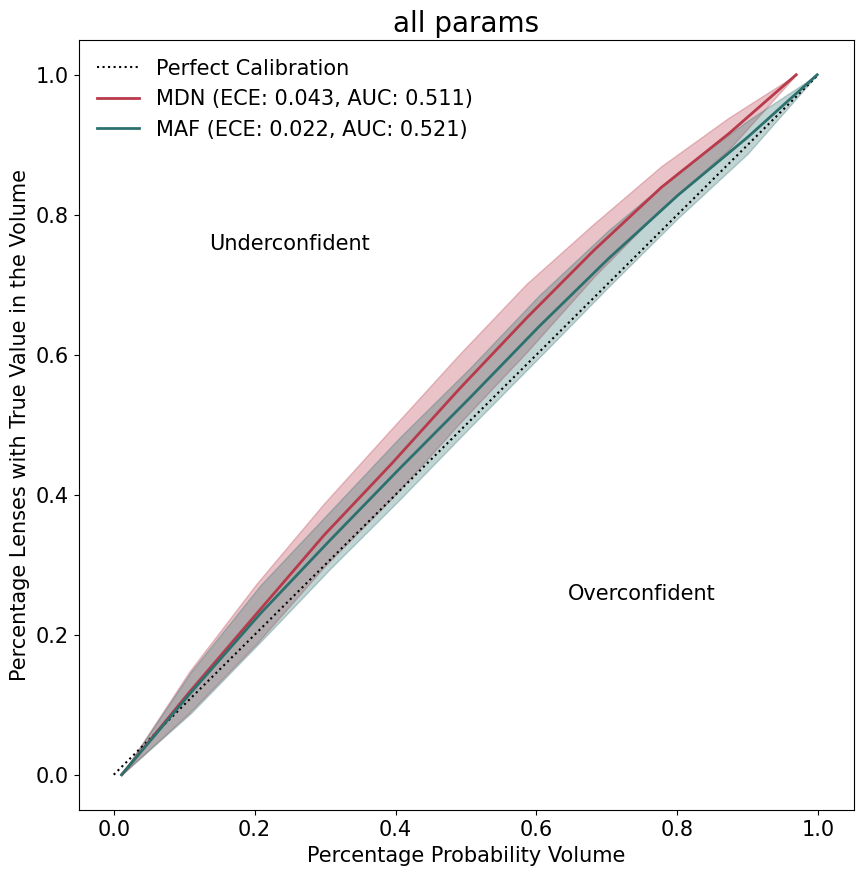

In [57]:
stanford_red = '#8C1515'
stanford_red_light = '#B83A4B'
stanford_green = '#175E54'
stanford_green_light = '#2D716F'
stanford_grey = '#53565A'
stanford_brown = '#5D4B3C'
stanford_brown_light ='#766253'
stanford_stone = '#7F7776'
stanford_fog = '#DAD7CB'
stanford_blue = '#016895'
stanford_blue_light = '#4298B5'
stanford_orange = '#E98300'
stanford_orange_light = '#F9A44A'
stanford_purple = '#620059'
stanford_purple_light = '#734675'

ecp, alpha, ecp_error = get_coverage(np.array(samples_mdn), np.array(thetas_obs), references = "random", metric = "euclidean", norm = True, bootstrap=True, sigma=1)
ecp2, alpha2, ecp_error2 = get_coverage(np.array(samples_maf), np.array(thetas_obs), references = "random", metric = "euclidean", norm = True, bootstrap=True, sigma=1)


ecp_list = [ecp, ecp2]
alpha_list = [alpha, alpha2]
ecp_error_list = [ecp_error, ecp_error2]
colors = [stanford_red_light, stanford_green_light]
legend_labels = ['MDN', 'MAF']
plot_coverage(alpha_list, ecp_list, ecp_error_list, colors, legend_labels, quality_metrics=['ECE', 'AUC'], title=r'all params')
plt.show()

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 22369.81it/s]


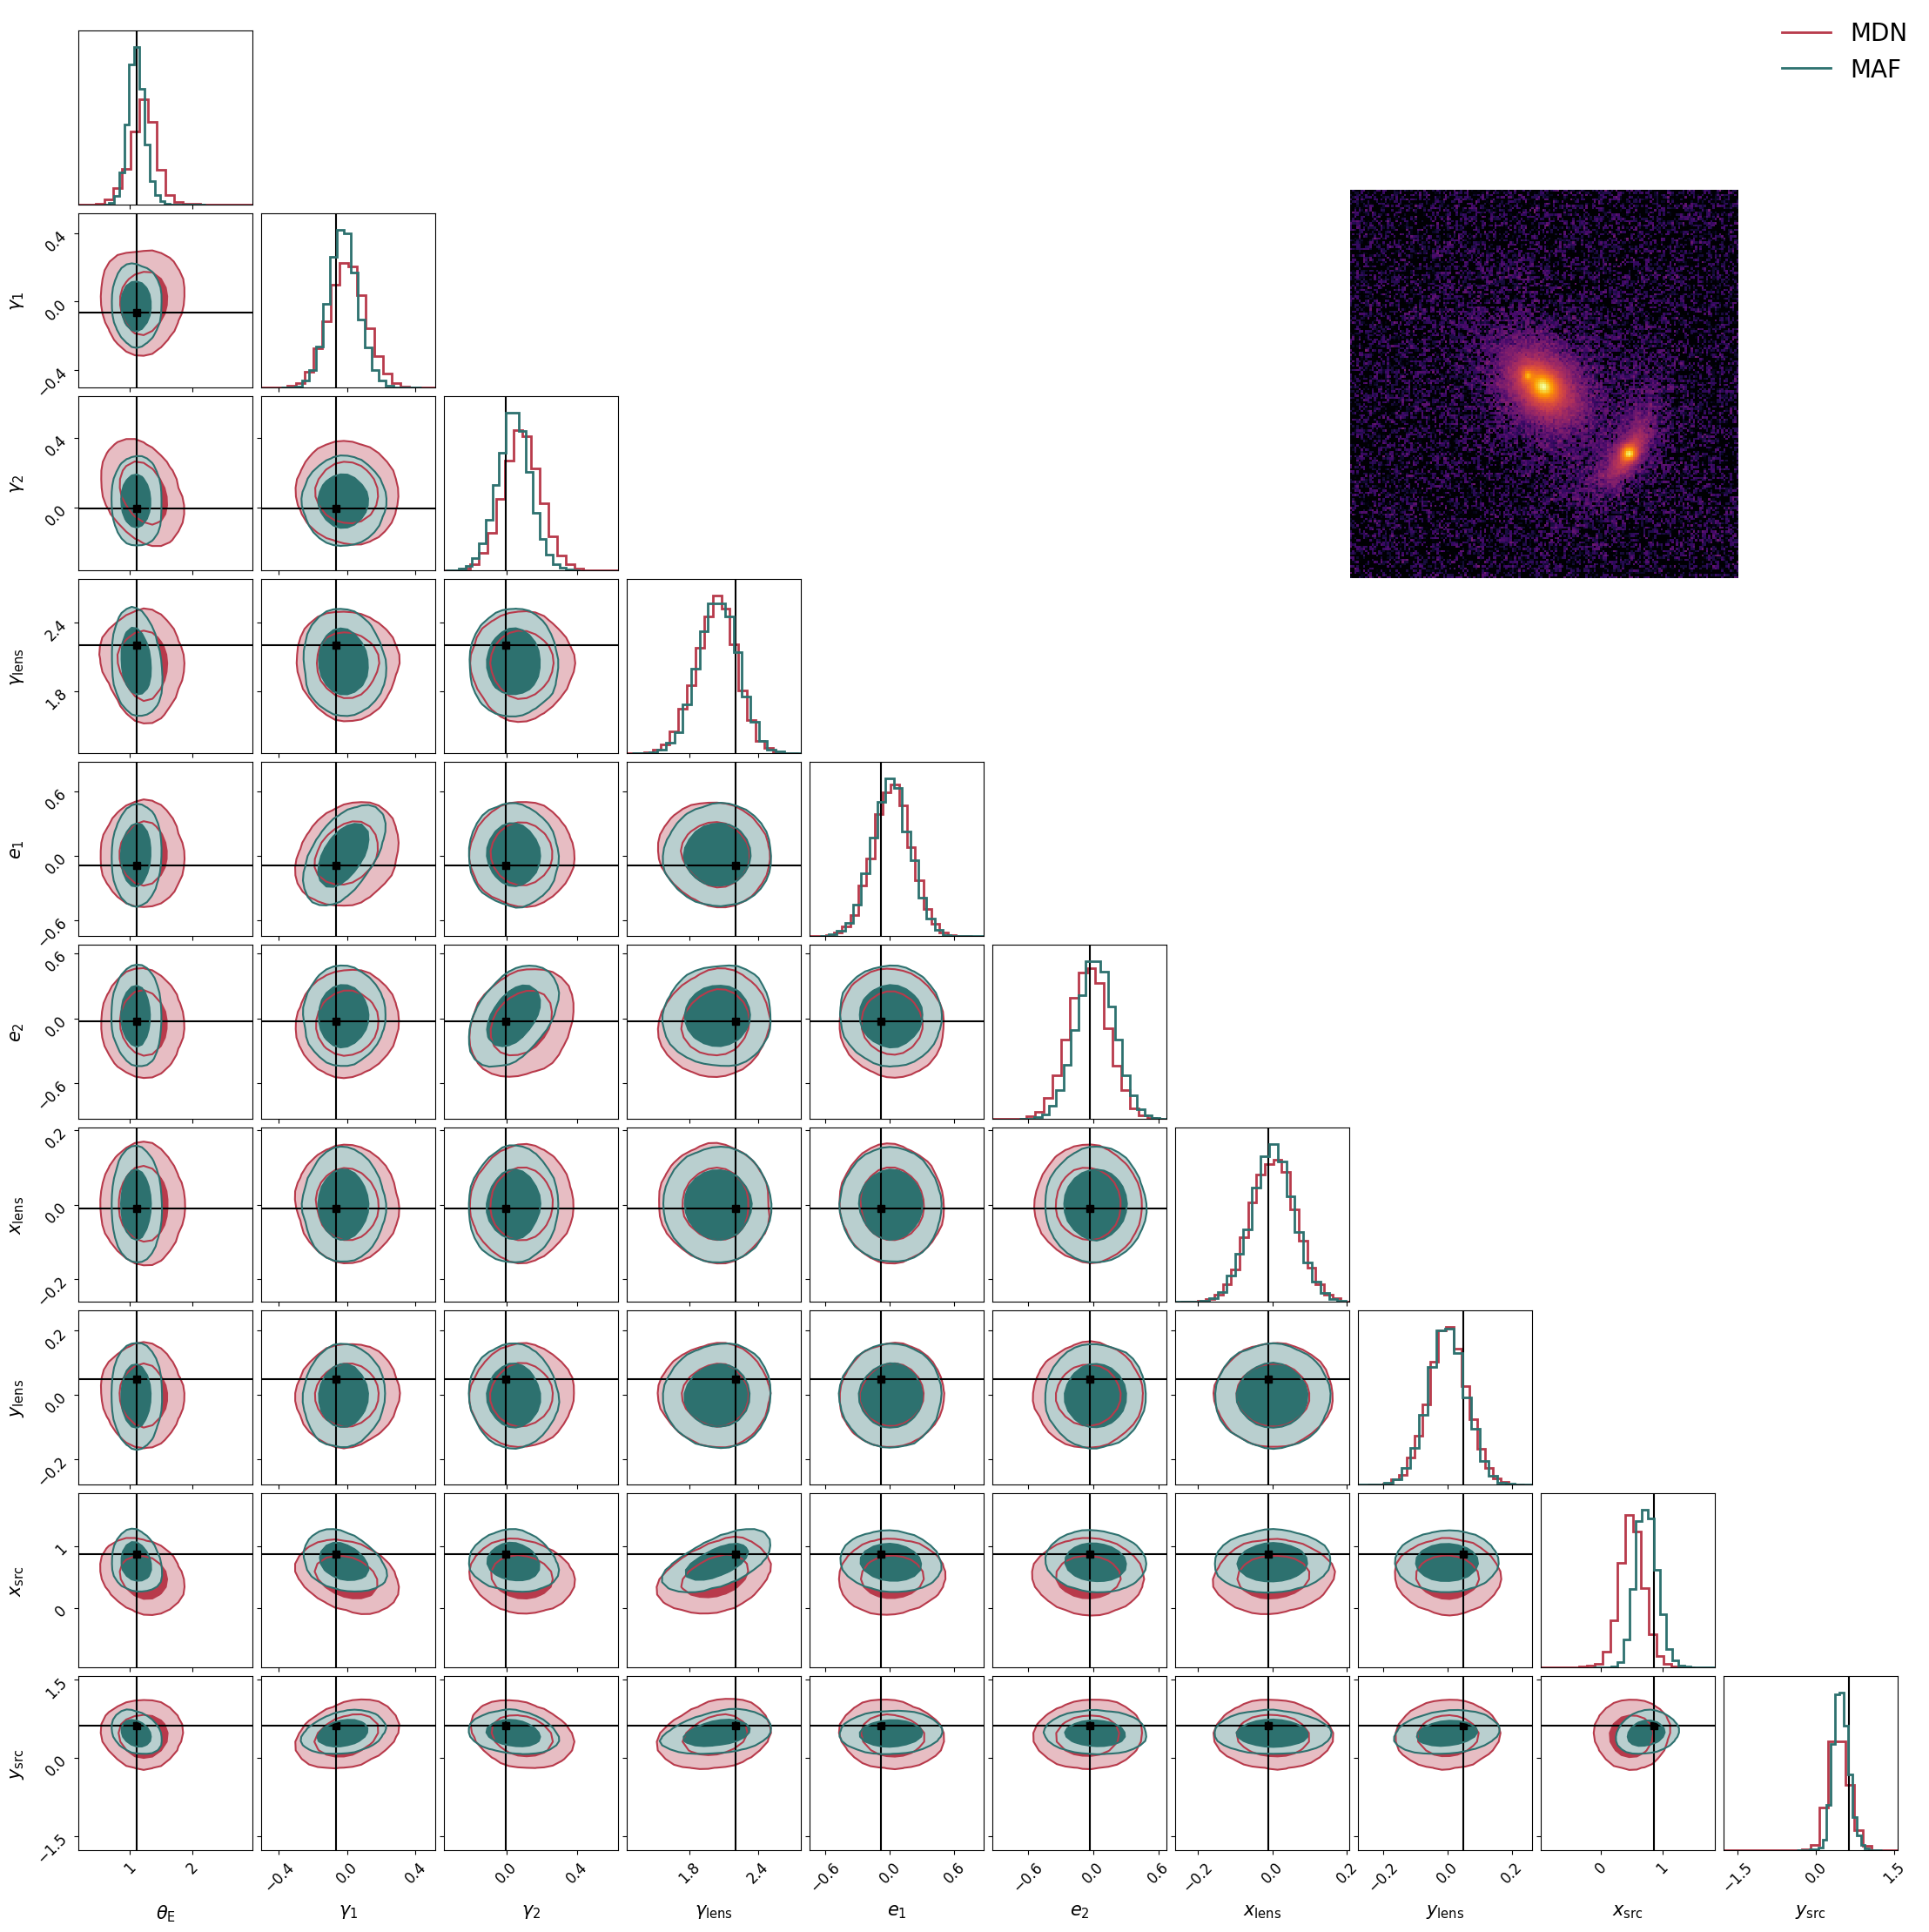

In [53]:
# Corner plot function

stanford_red = '#8C1515'
stanford_red_light = '#B83A4B'
stanford_green = '#175E54'
stanford_green_light = '#2D716F'
stanford_grey = '#53565A'
stanford_brown = '#5D4B3C'
stanford_brown_light ='#766253'
stanford_stone = '#7F7776'
stanford_fog = '#DAD7CB'
stanford_blue = '#016895'
stanford_blue_light = '#4298B5'
stanford_orange = '#E98300'
stanford_orange_light = '#F9A44A'
stanford_purple = '#620059'
stanford_purple_light = '#734675'

# custom color map
# create a colormap custom
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['black', stanford_brown_light, 'white'])

i = 15
samples2 = posterior_mdn.sample((10000,), x=x_obs[i])
samples3 = posterior_maf.sample((10000,), x=x_obs[i])
param_labels = [r'$\theta_\mathrm{E}$',r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_\mathrm{lens}$',r'$e_1$',
								r'$e_2$',r'$x_\mathrm{lens}$',r'$y_\mathrm{lens}$',r'$x_\mathrm{src}$',r'$y_\mathrm{src}$']

# Plot corner plot
truths = thetas_obs[i]

# f = plot_corner(np.array(theta_test), np.array(theta_test[i]), param_labels, stanford_stone,  show_titles=False, legend_label='Prior')
f = plot_corner(np.array(samples2), np.array(truths), param_labels, stanford_red_light, legend_label='MDN')
f = plot_corner_overlay(f, np.array(samples3), stanford_green_light, legend_label='MAF')
f = plot_corner_image(f, x_obs[i].numpy(), position=(0.7, 0.7, 0.2, 0.2), cmap='inferno')

# f = plot_corner_overlay(f, np.array(samples3), stanford_green_light, legend_label='three')
plt.show()



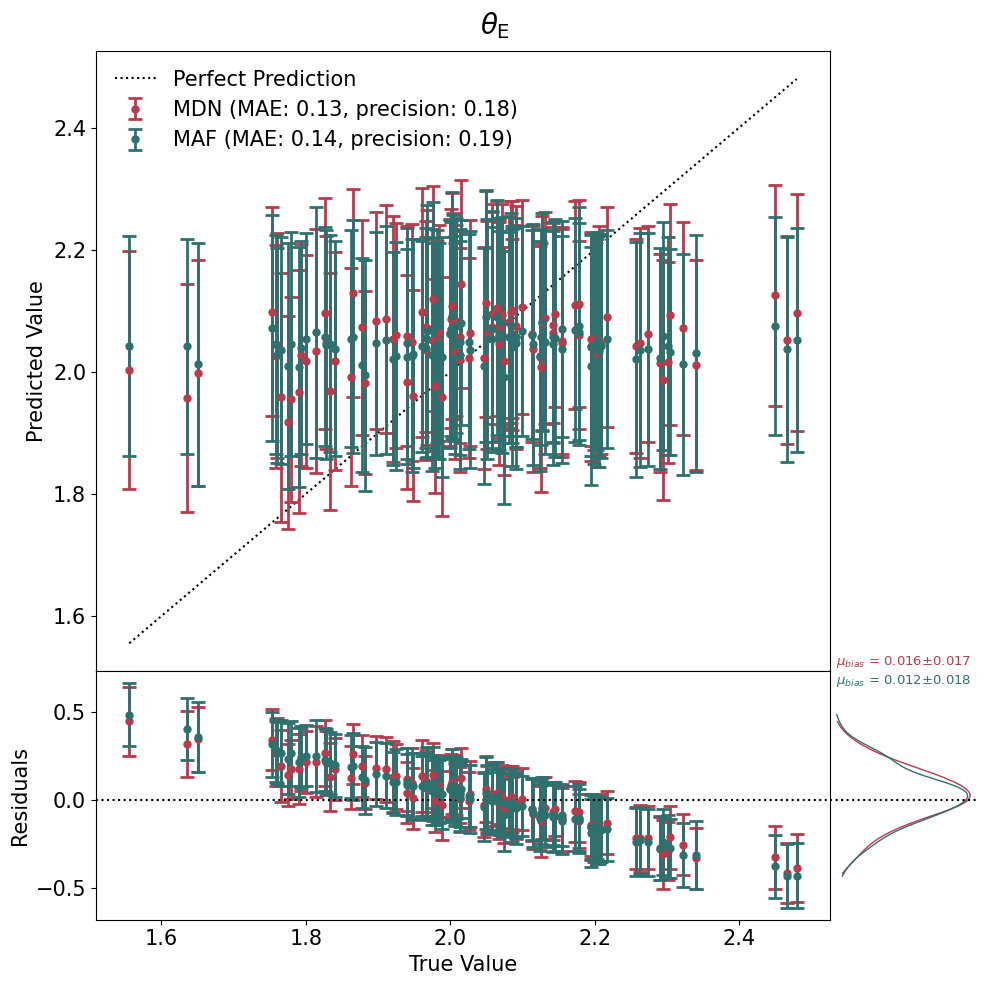

(<Axes: xlabel='True Value', ylabel='Predicted Value'>,
 <Axes: xlabel='True Value', ylabel='Residuals'>,
 <Axes: >)

In [69]:
stanford_red = '#8C1515'
stanford_red_light = '#B83A4B'
stanford_green = '#175E54'
stanford_green_light = '#2D716F'
stanford_grey = '#53565A'
stanford_brown = '#5D4B3C'
stanford_brown_light ='#766253'
stanford_stone = '#7F7776'
stanford_fog = '#DAD7CB'
stanford_blue = '#016895'
stanford_blue_light = '#4298B5'
stanford_orange = '#E98300'
stanford_orange_light = '#F9A44A'
stanford_purple = '#620059'
stanford_purple_light = '#734675'

def check_parity(true_values, predicted_values, error_values, quality_metrics = None):
        
        # Initialize quality metrics dictionary
        metric_values = {}

        # Calculate quality metrics if required
        if 'RMSE' in quality_metrics:
            metric_values['RMSE'] = np.sqrt(np.mean((np.array(predicted_values) - np.array(true_values)) ** 2))

        if 'MAE' in quality_metrics:
            metric_values['MAE'] = np.mean(np.abs(np.array(predicted_values) - np.array(true_values)))

        if 'precision' in quality_metrics:
            metric_values['precision'] = np.mean(error_values)

        return metric_values


# fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharey='row', sharex='col',
#                 gridspec_kw=dict(hspace=0, wspace=0, height_ratios=(3,1), width_ratios=(7,1)))
# ax[0,0].errorbar(bin_centers, counts_normalised, yerr=errors_normalised, fmt='.', color='black', label='Data')


# # Plot the fitted background, signal and total probability distributions
# ax[0,0].plot(M_vals, total_fit_vals, linestyle = '-', label='Total Fit (B+S)', color=sd2022_blue)
# ax[0,0].plot(M_vals, background_fit_vals, linestyle = '--', label='Background Fit (B)', color=sd2022_red)
# ax[0,0].plot(M_vals, signal_fit_vals, linestyle = '-.', label='Signal Fit (S)', color=sd2022_green)
# ax[0,0].set_ylabel('Probability Density (Components) / Normalised Counts')
import seaborn as sns
from scipy.stats import norm, gaussian_kde

def plot_parity(true_values, predicted_values_list, error_values_list,
                colors, legend_labels, residual_distr = 'step', quality_metrics=None, title=None):
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey='row', sharex='col',  gridspec_kw=dict(hspace=0, wspace=0, height_ratios=(2.5,1), width_ratios=(5,1)))
    scatter_ax, _, residual_ax, hist_ax  = axs.flatten()
    fig.suptitle(title, fontsize=20)
    
    # Draw y = x line for reference (perfect prediction)
    scatter_ax.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], color='k', linestyle=':', label='Perfect Prediction')
    
    residuals_all = []
    
    for i, (predicted_values, error_values, color, legend_label) in enumerate(zip(predicted_values_list, error_values_list, colors, legend_labels)):
        
        residuals = np.array(predicted_values) - np.array(true_values)
        residuals_all.extend(residuals)
        
        # Calculate quality metrics if required
        if quality_metrics is not None:
            metric_values = check_parity(true_values, predicted_values, error_values, quality_metrics = quality_metrics)
            metric_strings = [f"{key}: {value:.2f}" for key, value in metric_values.items()]
            legend_label += f' ({", ".join(metric_strings)})'
        
        # Plot parity plot
        scatter_ax.errorbar(
            true_values, predicted_values, yerr=error_values, fmt='.',
            color=color, markersize=10, capsize=5, elinewidth=2, capthick=2, label=legend_label
        )
        
        # Plot residuals
        residual_ax.errorbar(
            true_values, residuals, yerr=error_values, fmt='.', color=color,
            markersize=10, capsize=5, elinewidth=2, capthick=2
        )

        # Plot residuals histogram
        if residual_distr == 'step':
            hist_ax.hist(residuals, density=True, orientation='horizontal',  color=color, linewidth=1, histtype='step')
        elif residual_distr == 'kde':
            # hist_ax.hist(residuals, density=True, orientation='horizontal',  color=color, alpha = 0.3)
            kde = gaussian_kde(residuals)
            x_vals = np.linspace(min(residuals), max(residuals), 100)
            kde_vals = kde(x_vals)
            hist_ax.plot(kde_vals, x_vals, color=color, linestyle='-', linewidth=1)

        bias = np.mean(np.array(residuals))
        bias_error = np.std(np.array(residuals)) / np.sqrt(len(residuals))
        ypos = 1.0 - 0.5 * ((1-len(predicted_values_list)) * 0.075) - i*0.075
        hist_ax.text(0.5,  ypos, f"$\mu_{{bias}}$ = {bias:.3f}$\pm${bias_error:.3f}", horizontalalignment='center', transform=hist_ax.transAxes,size=9.5, color=color, verticalalignment='center')

    # Set labels and ticks for scatter plot
    scatter_ax.set_xlabel('True Value', fontsize=15)
    scatter_ax.set_ylabel('Predicted Value', fontsize=15)
    scatter_ax.tick_params(axis='both', which='major', labelsize=15)
    scatter_ax.legend(loc='upper left', fontsize=15, frameon=False)
    
    # Residual plot settings
    residual_ax.axhline(0, color='k', linestyle=':')
    residual_ax.set_xlabel('True Value', fontsize=15)
    residual_ax.set_ylabel('Residuals', fontsize=15)
    residual_ax.tick_params(axis='both', which='major', labelsize=15)
    
    # Residual histogram
    hist_ax.axhline(0, color='k', linestyle=':')
    
    # Hide the unused top-right subplot
    axs[0, 1].axis('off')
    hist_ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return scatter_ax, residual_ax, hist_ax

# Plot parity plot
param = 3
true_values = theta_test[:100][..., param]
predicted_values_list = [np.mean(np.array(samples_mdn[..., param]), axis=0), np.mean(np.array(samples_maf[..., param]), axis=0), np.mean(np.array(samples_maf[..., param]), axis=0)]
error_values_list = [np.std(np.array(samples_mdn[..., param]), axis=0), np.std(np.array(samples_maf[..., param]), axis=0), np.mean(np.array(samples_maf[..., param]), axis=0)]
colors = [stanford_red_light, stanford_green_light, stanford_blue_light]
legend_labels = ['MDN', 'MAF', 'NSF']
quality_metrics = ['RMSE', 'MAE', 'precision']

predicted_values_list = [np.mean(np.array(samples_mdn[..., param]), axis=0)]
error_values_list = [np.std(np.array(samples_mdn[..., param]), axis=0)]
colors = [stanford_green_light]
legend_labels = ['MDN']
quality_metrics = ['RMSE', 'MAE', 'precision']

predicted_values_list = [np.mean(np.array(samples_mdn[..., param]), axis=0), np.mean(np.array(samples_maf[..., param]), axis=0)]
error_values_list = [np.std(np.array(samples_mdn[..., param]), axis=0), np.std(np.array(samples_maf[..., param]), axis=0)]
colors = [stanford_red_light, stanford_green_light]
legend_labels = ['MDN', 'MAF']
quality_metrics = ['MAE', 'precision']


title = r'$\theta_\mathrm{E}$'
plot_parity(true_values, predicted_values_list, error_values_list, colors, legend_labels, 'kde', quality_metrics, title)




In [20]:
np.array(samples_mdn[..., 0])

array([[0.60770786, 0.94089967, 1.5588527 , ..., 1.4792411 , 0.8479047 ,
        0.6447917 ],
       [0.4866748 , 0.48713097, 1.4587578 , ..., 1.3122405 , 0.5899565 ,
        0.30396494],
       [0.6261761 , 0.6392044 , 1.5567775 , ..., 1.3297716 , 1.1075603 ,
        0.53750706],
       ...,
       [0.50140196, 0.3121494 , 1.3769506 , ..., 1.3590921 , 0.73675257,
        0.91809237],
       [0.51051325, 0.69777423, 1.507383  , ..., 1.3741286 , 0.6895298 ,
        0.59046507],
       [0.5371162 , 0.33452773, 1.308532  , ..., 1.2005168 , 1.2662034 ,
        0.6862406 ]], dtype=float32)

In [16]:
samples_mdn.shape

torch.Size([10000, 100, 10])